In [5]:
################################################################################
#
# This notebook is intended for comparing two financial scenarios.
#
################################################################################

import math
import matplotlib.pyplot as plt
import numpy as np
import plotting
import scipy as scipy
import simulation as sim
import mortgage as mg
from ipywidgets import *

# Plot the figures inline and not in a pop-up
%matplotlib inline

################################################################################
#                     SIMULATION PARAMETERS BELOW.                             #
################################################################################

# Specify the start year, end year, and retirement year for the simulation.
START_YEAR = 2020
END_YEAR = 2050
RETIREMENT_YEAR = 2050

# Specify the number of simulations of interest. Fewer simulations will run
# faster, but more simulations reduce the statistical uncertainty.
NUM_SIMULATIONS = 1000
THRESHOLD = 3000000.0

################################################################################
#                     SCENARIO A PARAMETERS BELOW.                             #
################################################################################

LABEL_A = 'Two Kids'

# Initial value of assets for the simulation.
INITIAL_ASSET_VALUE_A = 400000.0

# Payments reflect any sources of income or expenses. For example, salary is
# represented as a net positive payment, while living expenses and taxes are
# represented as net negative payments. To specify a payment, give it a name,
# an initial value, the percent annual change, the standard deviation of the
# amount of the payment, the year in which the payment starts, and the year in
# which the payment ends.
PAYMENTS_A = [  #          (name,                       sum,  change,  stdev,   start_year,           end_year)
    # Start high-paying job and spend a lot for 10 years.
    sim.recurring_payment('salary1',              520000,    1.08,   0.02,   START_YEAR,          START_YEAR + 10),
    sim.recurring_payment('expenses_working1',   -300000,    1.03,   0.05,   START_YEAR,          START_YEAR + 10),

    # Have a child
    sim.recurring_payment('childcare',            -50000,    1.03,   0.05,   START_YEAR+2,        START_YEAR + 20),
    sim.recurring_payment('childcare',            -40000,    1.03,   0.05,   START_YEAR+4,        START_YEAR + 22),
    
    # Switch jobs and reduce expenses.
    sim.recurring_payment('salary2',              500000,    1.02,   0.02,   START_YEAR + 10,      RETIREMENT_YEAR),
    sim.recurring_payment('expenses_working2',   -150000,    1.00,   0.10,   START_YEAR + 10,      RETIREMENT_YEAR),

    # Retirement.
    sim.recurring_payment('social_security',       34332,    1.02,   0.01,   RETIREMENT_YEAR,     END_YEAR),
    sim.recurring_payment('expenses_retirement',  -70000,    1.02,   0.05,   RETIREMENT_YEAR,     END_YEAR),
]

# Specify a mortgage, or alternatively set the MORTGAGE parameter to None.
# This will create an additional annual expense equal to the mortgage payment.
# The equity in the property will NOT be reflected in the portfolio value.
MORTGAGE_A = mg.mortgage(
    principal_loan_amount=1600000,
    loan_down_payment=400000,
    annual_interest_rate=0.02,
    mortgage_term_years=30,
    start_year=START_YEAR + 2,
)
#MORTGAGE_A = None

################################################################################
#                     SCENARIO B PARAMETERS BELOW.                             #
################################################################################

LABEL_B = 'No Kids'

# Initial value of assets for the simulation.
INITIAL_ASSET_VALUE_B = 400000.0

PAYMENTS_B = [  #          (name,                       sum,  change,  stdev,   start_year,           end_year)
    # Start high-paying job and spend a lot for 10 years.
    sim.recurring_payment('salary1',              520000,    1.08,   0.02,   START_YEAR,          START_YEAR + 10),
    sim.recurring_payment('expenses_working1',   -300000,    1.03,   0.05,   START_YEAR,          START_YEAR + 10),

    # Have a child
    #sim.recurring_payment('childcare',            -50000,    1.03,   0.05,   START_YEAR+2,        START_YEAR + 20),
    #sim.recurring_payment('childcare',            -40000,    1.03,   0.05,   START_YEAR+4,        START_YEAR + 22),
    
    # Switch jobs and reduce expenses.
    sim.recurring_payment('salary2',              500000,    1.02,   0.02,   START_YEAR + 10,      RETIREMENT_YEAR),
    sim.recurring_payment('expenses_working2',   -150000,    1.00,   0.10,   START_YEAR + 10,      RETIREMENT_YEAR),

    # Retirement.
    sim.recurring_payment('social_security',       34332,    1.02,   0.01,   RETIREMENT_YEAR,     END_YEAR),
    sim.recurring_payment('expenses_retirement',  -70000,    1.02,   0.05,   RETIREMENT_YEAR,     END_YEAR),
]

# Specify a mortgage, or alternatively set the MORTGAGE parameter to None.
# This will create an additional annual expense equal to the mortgage payment.
# The equity in the property will NOT be reflected in the portfolio value.
MORTGAGE_B = mg.mortgage(
    principal_loan_amount=1600000,
    loan_down_payment=400000,
    annual_interest_rate=0.02,
    mortgage_term_years=30,
    start_year=START_YEAR + 2,
)
#MORTGAGE_B = None

################################################################################
#                          Experts only below here.                            #
################################################################################

In [6]:
def get_prob_a_lower_than_b(hist_a, hist_b):
    
    # histograms are arrays with weights, then x-axis bin centers.
    # array([   0.,    0.,    0.,    0.,    0.,    0.,    2.,   51.,  170.,
    #    264.,  183.,  120.,   88.,   49.,   39.,   15.,    3.,    9.,
    #      3.,    2.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,
    #      0.,    0.,    0.]), array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
    #   2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
    #   2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]

    # note: be sure to normalize p(a) and p(b) first.
    sum_a = np.sum(hist_a[0])
    sum_b = np.sum(hist_b[0])

    sum_ab = 0.0

    # loop over bin centers.
    for i in range(len(hist_a[0])):
        # get p(a)
        p_a = hist_a[0][i] / sum_a
        #print("p_a = ", p_a)
        # get integral (p(b)) from bin 0 to curr bin center
        int_p_b = np.sum(hist_b[0][:i]) / sum_b
        #print("int_p_b = ", int_p_b)
        # compute p(a) * integral p(b)
        joint_ab = p_a * int_p_b
        #print("joint_ab = ", joint_ab)
        # add up these values as you scan bin centers.
        sum_ab = sum_ab + joint_ab
    return sum_ab

In [7]:
def graph_update(rate_of_return, rate_of_return_stddev):

    annual_rate_of_return = sim.simulated_parameter(
        'annual_rate_of_return',
        rate_of_return,
        rate_of_return_stddev,
        START_YEAR,
        END_YEAR
    )

    values_a, incomes_a = sim.simulate_portfolio(
        INITIAL_ASSET_VALUE_A,
        annual_rate_of_return,
        PAYMENTS_A,
        MORTGAGE_A,
        START_YEAR,
        END_YEAR,
        NUM_SIMULATIONS)
    values_b, incomes_b = sim.simulate_portfolio(
        INITIAL_ASSET_VALUE_B,
        annual_rate_of_return,
        PAYMENTS_B,
        MORTGAGE_B,
        START_YEAR,
        END_YEAR,
        NUM_SIMULATIONS)

    years = range(START_YEAR, END_YEAR + 1, 1)
    
    # Plot of the expected annual income per year.
    #plotting.plot_ci(years, incomes_a, 'Year', 'Net Income [$]', 'Income', START_YEAR, END_YEAR)
    plotting.plot_two_ci(years, incomes_a, incomes_b, LABEL_A, LABEL_B,
                         'Year', 'Net Income [$]', 'Income', START_YEAR, END_YEAR,
                         logy=False)
    
    # Plot of the expected portfolio value by year.
    plotting.plot_two_ci(years, values_a, values_b, LABEL_A, LABEL_B,
                         'Year', 'Value [$]', 'Portfolio Value', START_YEAR, END_YEAR,
                         logy=True)
    
    # Plot the expected dates for reaching a certain portfolio value.
    dates_a = plotting.get_crossing_dates(values_a, years, THRESHOLD)
    dates_a.sort()
    mean_dates_a = np.mean(dates_a)
    print("median crossing, %s = %d" % (LABEL_A, int(math.floor(mean_dates_a))))
    dates_b = plotting.get_crossing_dates(values_b, years, THRESHOLD)
    dates_b.sort()
    mean_dates_b = np.mean(dates_b)
    print("median crossing, %s = %d" % (LABEL_B, int(math.floor(mean_dates_b))))

    if len(dates_a) > 0 and len(dates_b) > 0:
        fig, ax = plt.subplots(figsize=(10,5))
        hist_a = ax.hist(dates_a, bins=years, histtype='bar', facecolor='g',
                         alpha=0.4, range=(years[0], years[-1]), label=LABEL_A)
        hist_b = ax.hist(dates_b, bins=years, histtype='bar', facecolor='b',
                         alpha=0.4, range=(years[0], years[-1]), label=LABEL_B)
        ax.set(xlabel='Year', ylabel='Number of Simulations',
               title='Year to reach $%2.1f' % THRESHOLD)
        ax.legend(loc='best')
        prob_a_lower_than_b = get_prob_a_lower_than_b(hist_a, hist_b)
        print("Prob(%s assets < %s assets) = %2.2f" % (LABEL_A, LABEL_B, 100.0 * prob_a_lower_than_b) + "%")
    else:
        print("one or more threshold histograms are empty.")

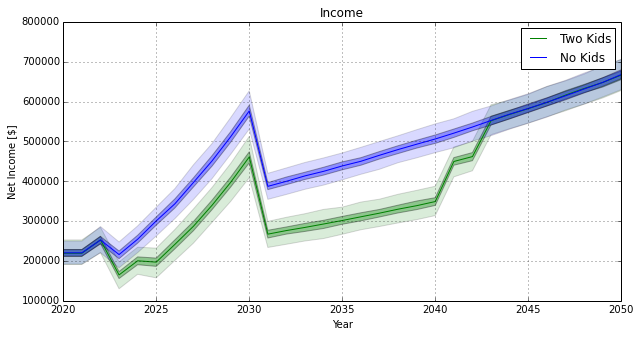

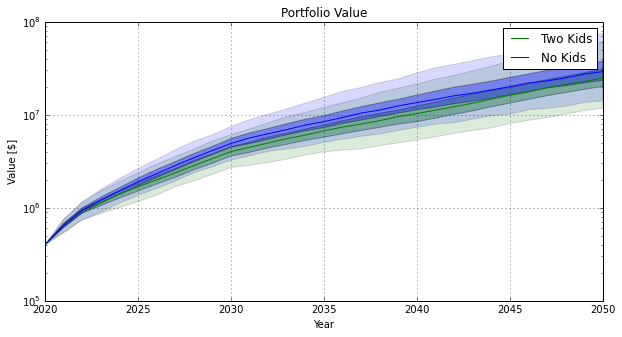

median crossing, Two Kids = 2027
median crossing, No Kids = 2026
Prob(Two Kids assets < No Kids assets) = 61.19%


<function __main__.graph_update>

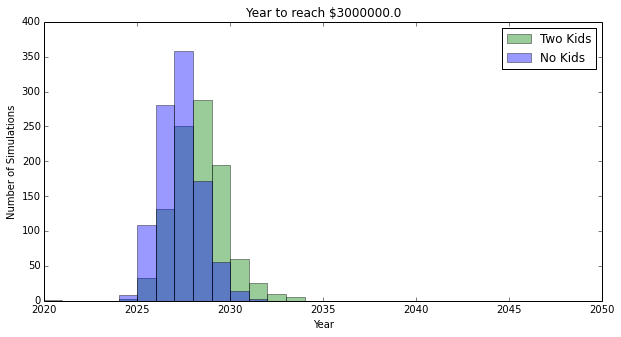

In [8]:
interact(
    graph_update,
    rate_of_return=widgets.FloatSlider(
        value=1.06,
        min=0.8,
        max=1.2,
        step=0.01),
    rate_of_return_stddev=widgets.FloatSlider(
        value=0.15,
        min=0.000001,
        max=0.2,
        step=0.01))